In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [2]:
sns.set()

df = pd.read_csv("../../data/datasets_modal_spx_train.csv")
df_test = pd.read_csv("../../data/datasets_modal_spx_test.csv")

In [3]:
df_train = df
df_train["date"] = pd.to_datetime(df_train["date"])
df_train['day'] = pd.DatetimeIndex(df_train["date"]).day
df_train['day of week'] = pd.DatetimeIndex(df_train["date"]).dayofweek
df_train['day of week'] = df_train['day of week'].astype(str)
df_train['day of week'] = df_train['day of week'].replace([str(0),str(1),str(2),str(3),str(4)],['MON','TUE','WED','THU','FRI'])
df_train['month'] = pd.DatetimeIndex(df_train["date"]).month
df_train['year'] = pd.DatetimeIndex(df_train["date"]).year
df_train = df_train.set_index('date')
df_train.head()

,close,day,day of week,month,year
date,,,,,
1986-01-02,209.59,2,THU,1,1986
1986-01-03,210.88,3,FRI,1,1986
1986-01-06,210.65,6,MON,1,1986
1986-01-07,213.80,7,TUE,1,1986
1986-01-08,207.97,8,WED,1,1986


In [4]:
df_train_week = df
df_train_week["date"] = pd.to_datetime(df_train_week["date"])
df_train_week = df_train_week.groupby([pd.Grouper(key='date', freq='W-SUN')])['close'].mean().reset_index()
df_train_week['month'] = pd.DatetimeIndex(df_train_week["date"]).month
df_train_week['year'] = pd.DatetimeIndex(df_train_week["date"]).year
df_train_week = df_train_week.set_index('date')
df_train_week.head()

,close,month,year
date,,,
1986-01-05,210.235,1,1986
1986-01-12,208.898,1,1986
1986-01-19,207.844,1,1986
1986-01-26,205.498,1,1986
1986-02-02,209.720,2,1986


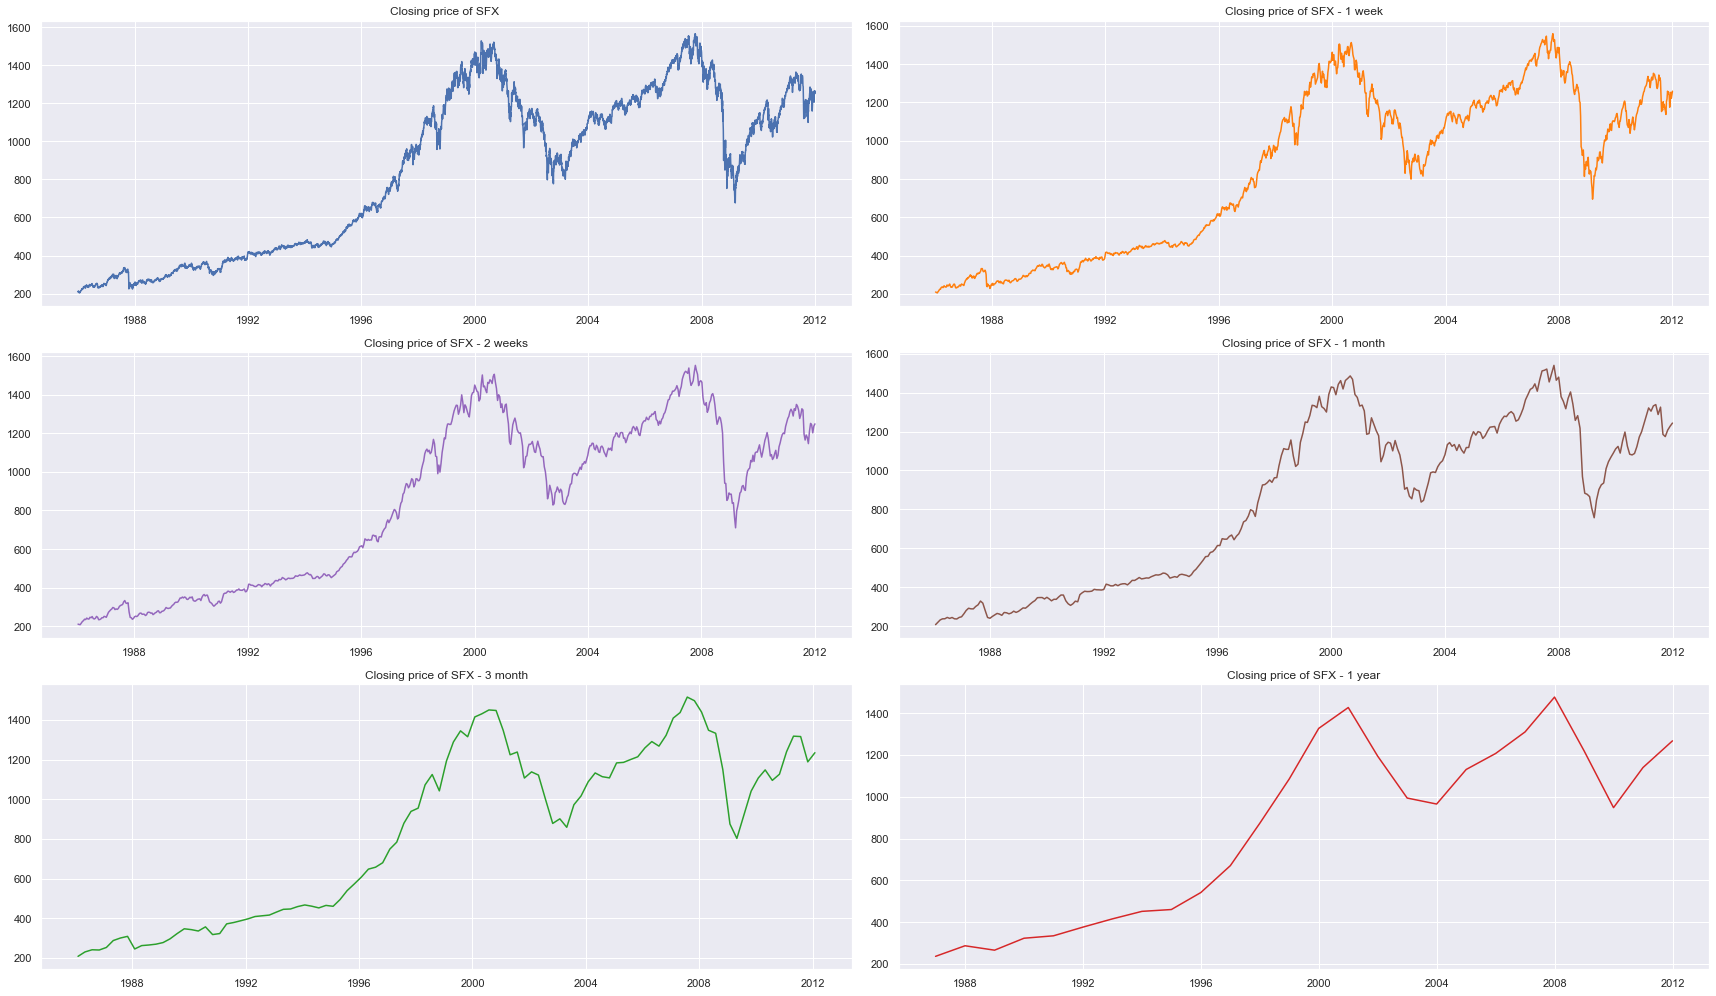

In [5]:
#2 weeks table
df_train_2_week = df
df_train_2_week["date"] = pd.to_datetime(df_train_2_week["date"])
df_train_2_week = df_train_2_week.groupby([pd.Grouper(key='date', freq='2W-SUN')])['close'].mean().reset_index()
df_train_2_week = df_train_2_week.set_index('date')

#month table
df_train_month = df
df_train_month["date"] = pd.to_datetime(df_train_month["date"])
df_train_month = df_train_month.groupby([pd.Grouper(key='date', freq='M')])['close'].mean().reset_index()
df_train_month = df_train_month.set_index('date')

#3 month table
df_train_3_month = df
df_train_3_month["date"] = pd.to_datetime(df_train_3_month["date"])
df_train_3_month = df_train_3_month.groupby([pd.Grouper(key='date', freq='3M')])['close'].mean().reset_index()
df_train_3_month = df_train_3_month.set_index('date')

#year table
df_train_year = df
df_train_year["date"] = pd.to_datetime(df_train_year["date"])
df_train_year = df_train_year.groupby([pd.Grouper(key='date', freq='Y')])['close'].mean().reset_index()
df_train_year = df_train_year.set_index('date')


#Printing the tables
fig, axs = plt.subplots(3, 2, figsize=(24, 14))
axs[0, 0].plot(df_train.close)
axs[0, 0].set_title('Closing price of SFX ')
axs[0, 1].plot(df_train_week.close, 'tab:orange')
axs[0, 1].set_title('Closing price of SFX - 1 week')
axs[1, 0].plot(df_train_2_week.close, 'tab:purple')
axs[1, 0].set_title('Closing price of SFX - 2 weeks')
axs[1, 1].plot(df_train_month.close, 'tab:brown')
axs[1, 1].set_title('Closing price of SFX - 1 month')
axs[2, 0].plot(df_train_3_month.close, 'tab:green')
axs[2, 0].set_title('Closing price of SFX - 3 month')
axs[2, 1].plot(df_train_year.close, 'tab:red')
axs[2, 1].set_title('Closing price of SFX - 1 year')
fig.tight_layout()

Text(0, 0.5, 'Close price')

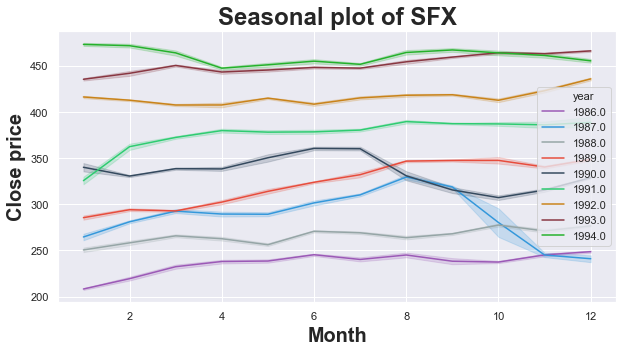

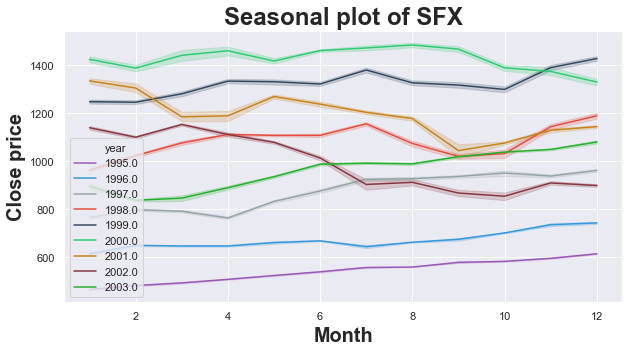

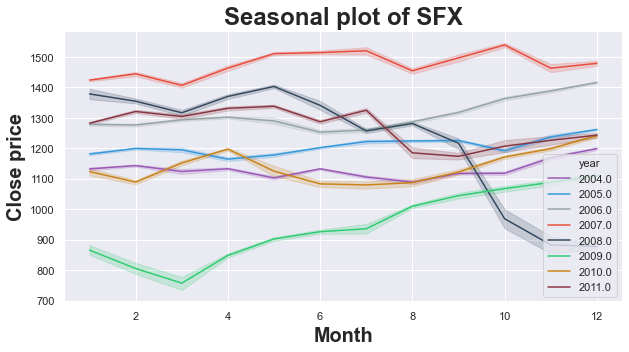

In [6]:
#Printing 1986-1994 Seasonal plot
fig, ax = plt.subplots(figsize=(10, 5))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#c98319","#883641",'#24b12b']
palette = sns.color_palette(flatui, 9)
sns.lineplot(df_train['month'], df_train['close'], hue=df_train['year']['1986':'1994'], palette=palette)
ax.set_title('Seasonal plot of SFX', fontsize = 24, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 20, fontdict=dict(weight='bold'))
ax.set_ylabel('Close price', fontsize = 20, fontdict=dict(weight='bold')) 

#Printing 1995-2003 Seasonal plot
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(df_train['month'], df_train['close'], hue=df_train['year']['1995':'2003'], palette=palette)
ax1.set_title('Seasonal plot of SFX', fontsize = 24, loc='center', fontdict=dict(weight='bold'))
ax1.set_xlabel('Month', fontsize = 20, fontdict=dict(weight='bold'))
ax1.set_ylabel('Close price', fontsize = 20, fontdict=dict(weight='bold')) 

#Printing 2004-2011 Seasonal plot
fig, ax2 = plt.subplots(figsize=(10, 5))
palette = sns.color_palette(flatui, 8)
sns.lineplot(df_train['month'], df_train['close'], hue=df_train['year']['2004':'2011'], palette=palette)
ax2.set_title('Seasonal plot of SFX', fontsize = 24, loc='center', fontdict=dict(weight='bold'))
ax2.set_xlabel('Month', fontsize = 20, fontdict=dict(weight='bold'))
ax2.set_ylabel('Close price', fontsize = 20, fontdict=dict(weight='bold'))

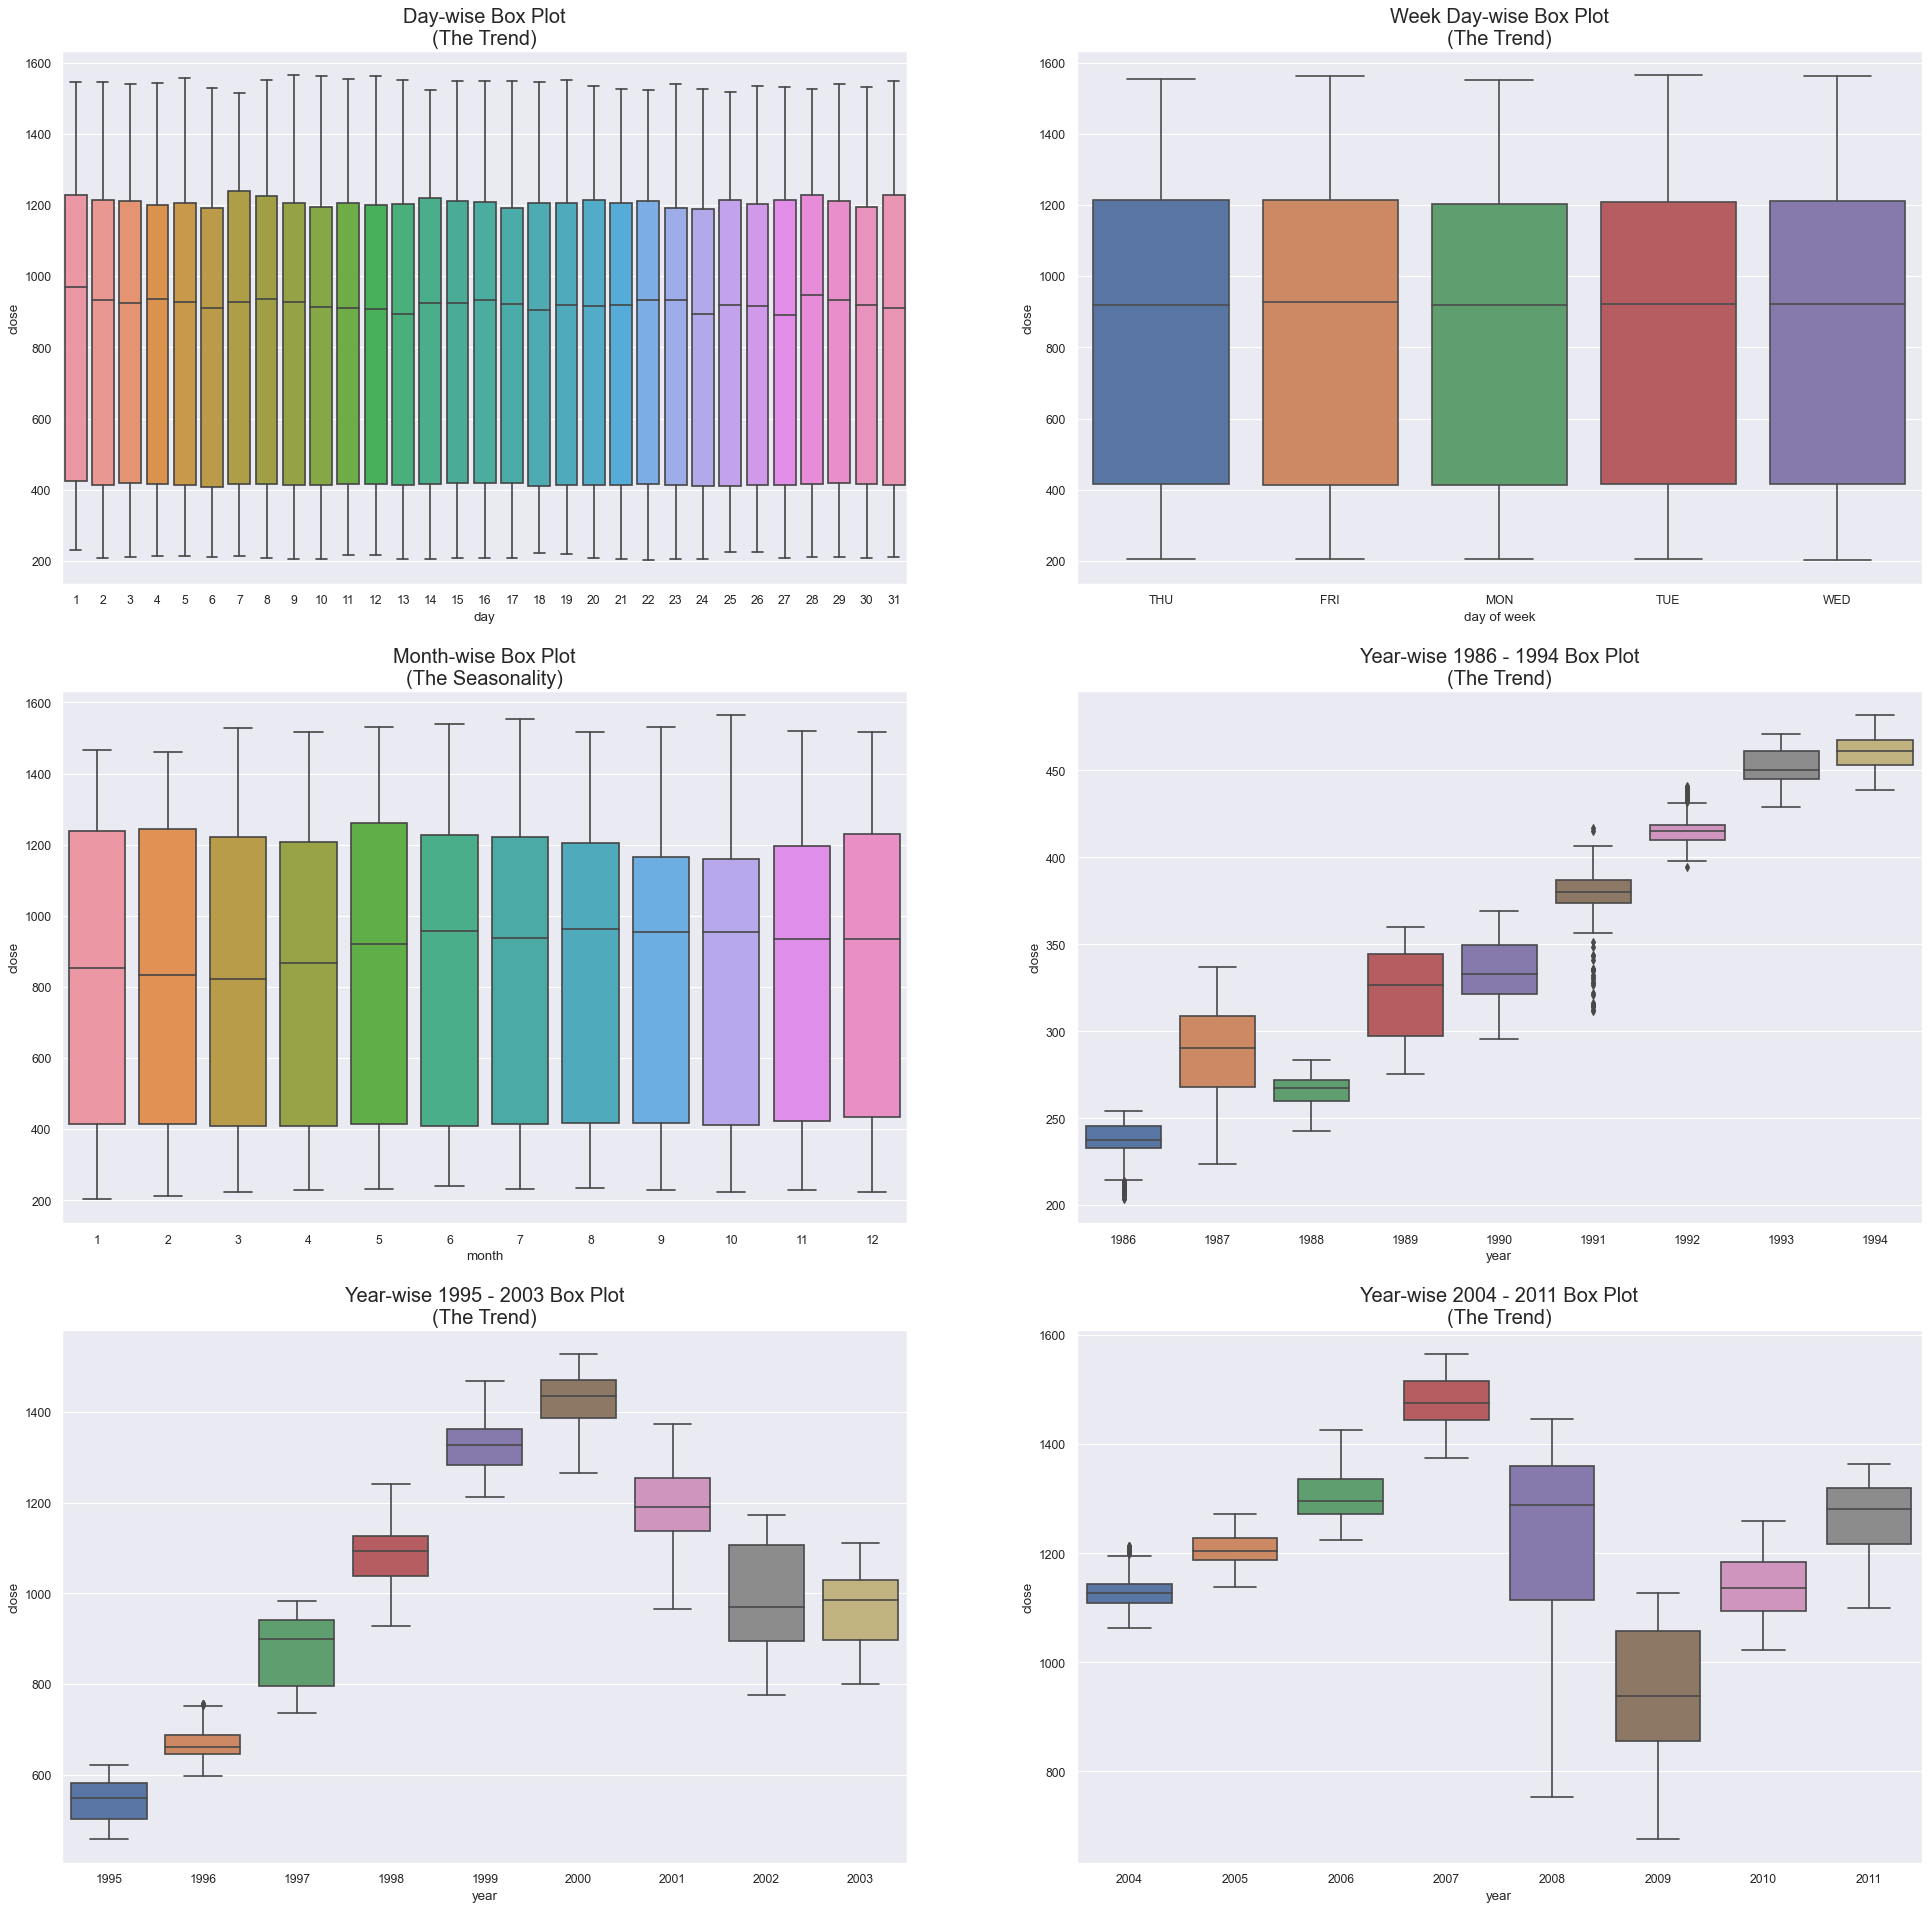

In [7]:
# Draw Plot
fig, axes = plt.subplots(3, 2, figsize=(30,30), dpi= 80)
sns.boxplot(x='day', y='close', data=df_train, ax=axes[0,0])
sns.boxplot(x='day of week', y='close', data=df_train, ax=axes[0,1])
sns.boxplot(x='month', y='close', data=df_train, ax=axes[1,0])
sns.boxplot(x='year', y='close', data=df_train['1986':'1994'], ax=axes[1,1])
sns.boxplot(x='year', y='close', data=df_train['1995':'2003'], ax=axes[2,0])
sns.boxplot(x='year', y='close', data=df_train['2004':'2011'], ax=axes[2,1])


# Set Title
axes[0,0].set_title('Day-wise Box Plot\n(The Trend)', fontsize=18);
axes[0,1].set_title('Week Day-wise Box Plot\n(The Trend)', fontsize=18);
axes[1,0].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1,1].set_title('Year-wise 1986 - 1994 Box Plot\n(The Trend)', fontsize=18);
axes[2,0].set_title('Year-wise 1995 - 2003 Box Plot\n(The Trend)', fontsize=18);
axes[2,1].set_title('Year-wise 2004 - 2011 Box Plot\n(The Trend)', fontsize=18);

plt.show()

In [8]:
# ADF Test
result = adfuller(df_train.close.values, autolag='aic')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_train.close.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.2442901251790845
p-value: 0.654259122183702
Critial Values:
   1%, -3.4313528936413693
Critial Values:
   5%, -2.861983193320384
Critial Values:
   10%, -2.5670059084209838

KPSS Statistic: 14.804652
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Pichau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Pichau\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


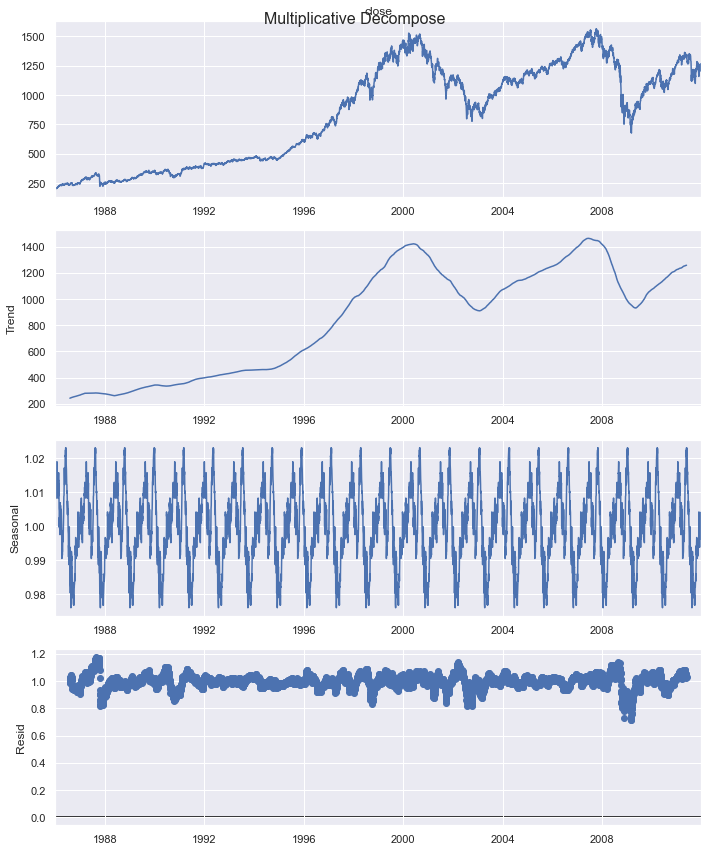

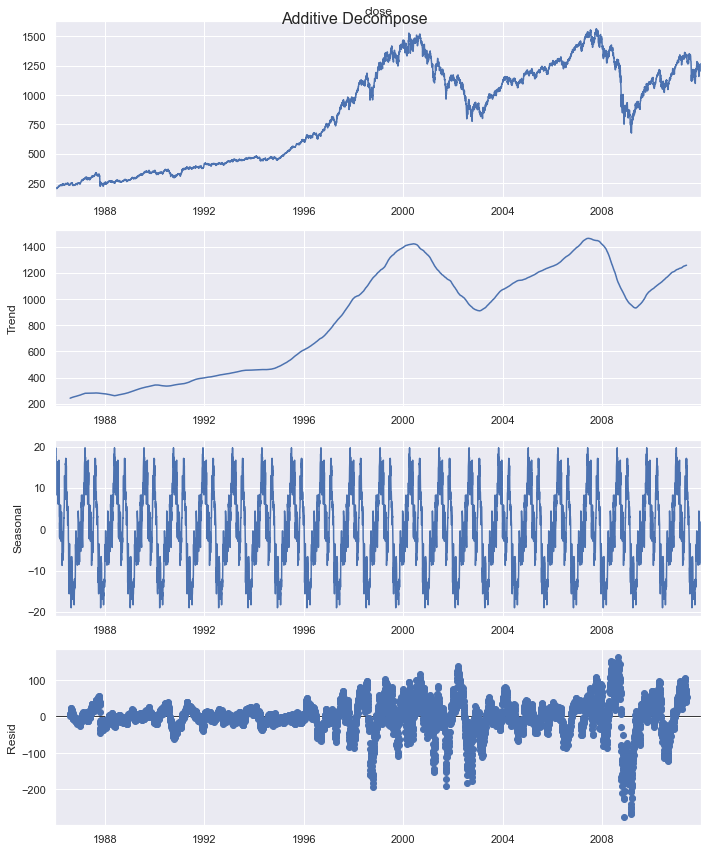

In [9]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_train['close'], model='multiplicative', period = 300)

# Additive Decomposition
result_add = seasonal_decompose(df_train['close'], model='additive', period = 300)

# Plot
plt.rcParams.update({'figure.figsize': (10,12)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
result_add.plot().suptitle('Additive Decompose', fontsize=16)
plt.show()

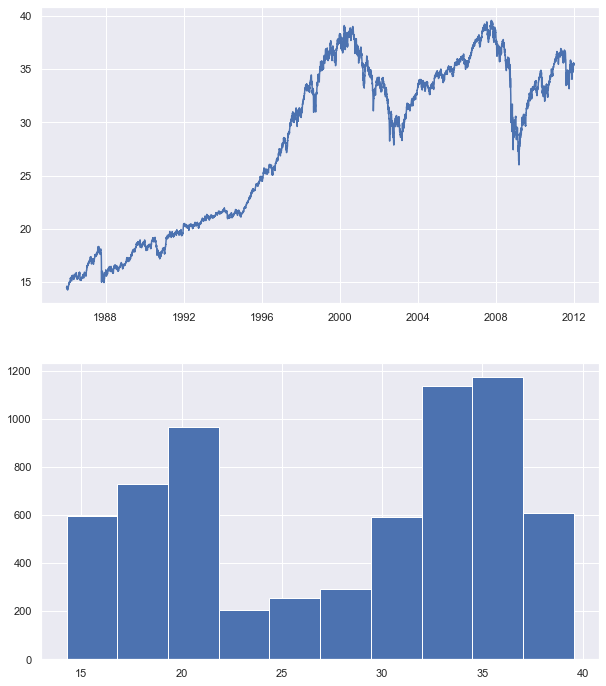

In [10]:
df_train_boxcox_sqr = df
df_train_boxcox_sqr = df_train_boxcox_sqr.drop(columns=['day', 'day of week', 'month', 'year'])
df_train_boxcox_sqr = df_train_boxcox_sqr.set_index('date')
df_train_boxcox_sqr.columns = ['close']
df_train_boxcox_sqr['close'] = np.sqrt(df_train_boxcox_sqr['close'])
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(df_train_boxcox_sqr['close'])
# histogram
plt.subplot(212)
plt.hist(df_train_boxcox_sqr['close'])
plt.show()


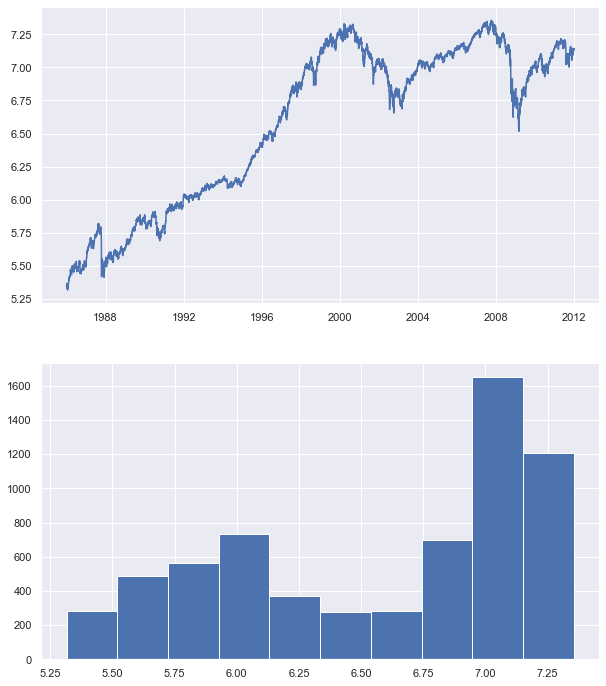

In [11]:
df_train_boxcox_log = df
df_train_boxcox_log= df_train_boxcox_log.drop(columns=['day', 'day of week', 'month', 'year'])
df_train_boxcox_log = df_train_boxcox_log.set_index('date')
df_train_boxcox_log.columns = ['close']
df_train_boxcox_log['close'] = np.log(df_train_boxcox_log['close'])
plt.figure(1)
# line plot
plt.subplot(211)
plt.plot(df_train_boxcox_log['close'])
# histogram
plt.subplot(212)
plt.hist(df_train_boxcox_log['close'])
plt.show()

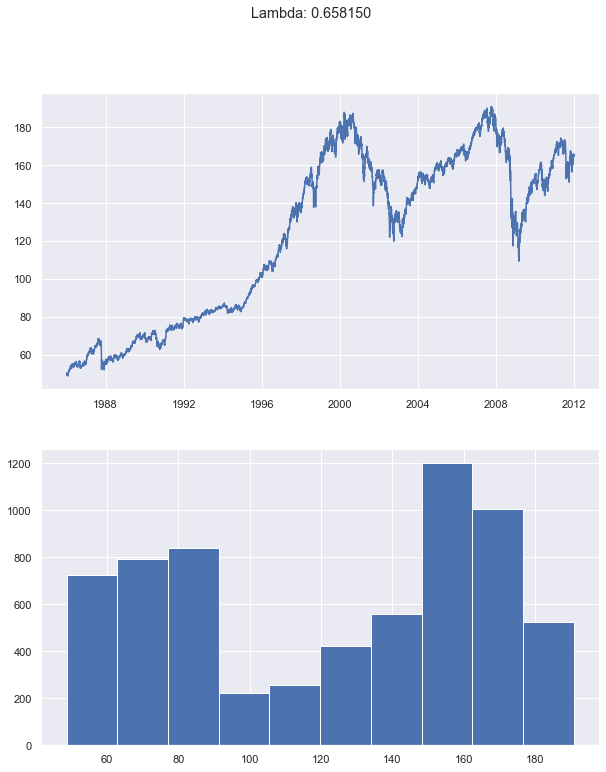

In [12]:
df_train_boxcox = df
df_train_boxcox = df_train_boxcox.drop(columns=['day', 'day of week', 'month', 'year'])
df_train_boxcox = df_train_boxcox.set_index('date')
df_train_boxcox.columns = ['close']
df_train_boxcox['close'], lam = boxcox(df_train_boxcox['close'])
plt.figure(1)
plt.suptitle('Lambda: %f' % lam)
# line plot
plt.subplot(211)
plt.plot(df_train_boxcox['close'])
# histogram
plt.subplot(212)
plt.hist(df_train_boxcox['close'])
plt.show()



### Parte 2 - Previsões

In [13]:
df_test["date"] = pd.to_datetime(df_test["date"])
df_test = df_test.set_index('date')

df_train_2 = df
df_train_2["date"] = pd.to_datetime(df_train_2["date"])
df_train_2 = df_train_2.set_index('date')

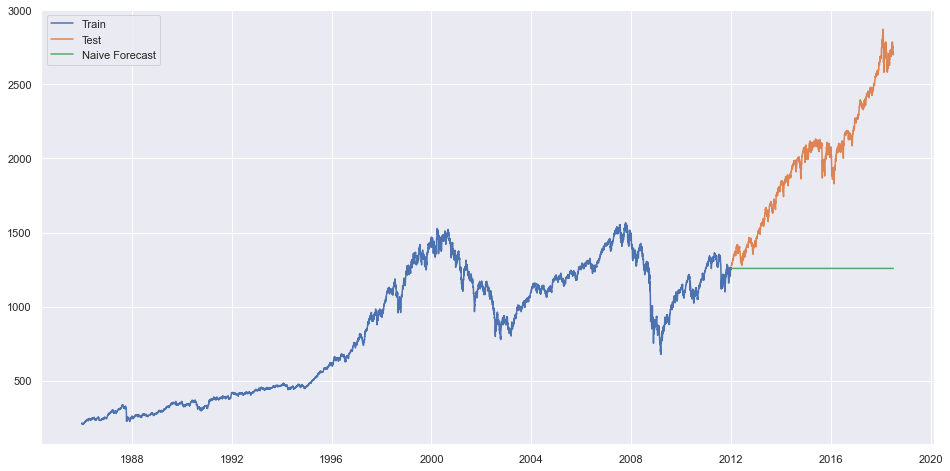

In [14]:
dd= np.asarray(df_train_2.close)
y_hat = df_test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(16,8))
plt.plot(df_train_2.index, df_train_2['close'], label='Train')
plt.plot(df_test.index,df_test['close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.show()

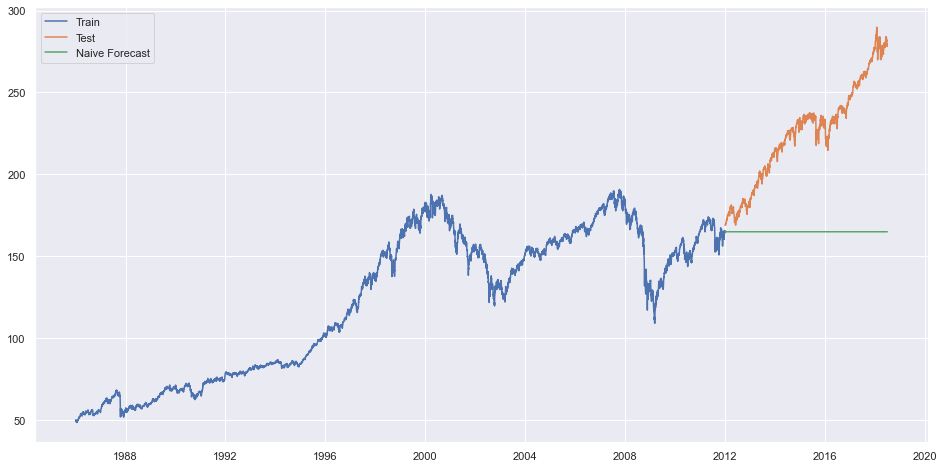

In [15]:
df_train_boxcox_test = df_test
df_train_boxcox_test.columns = ['close']
df_train_boxcox_test['close'], lam = boxcox(df_train_boxcox_test['close'])

dd= np.asarray(df_train_boxcox.close)
y_hat = df_train_boxcox_test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(16,8))
plt.plot(df_train_boxcox.index, df_train_boxcox['close'], label='Train')
plt.plot(df_train_boxcox_test.index,df_train_boxcox_test['close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.show()

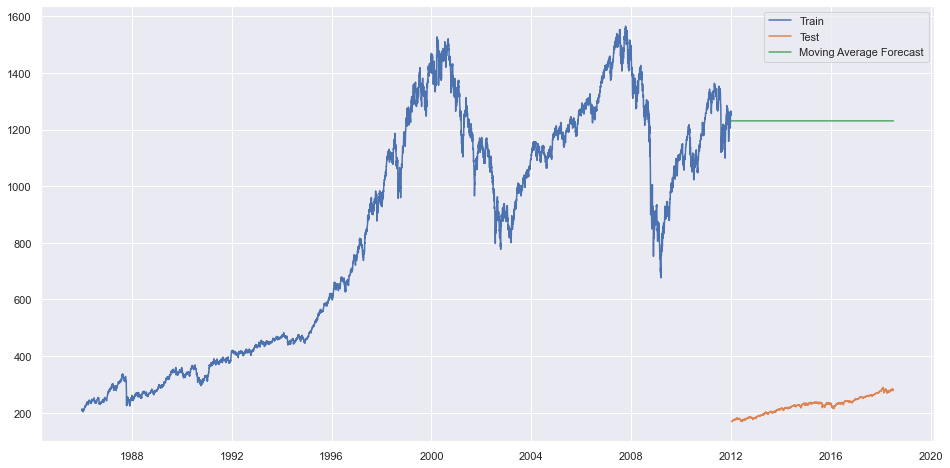

In [16]:
y_hat_avg = df_test.copy()
y_hat_avg['moving_avg_forecast'] = df_train_2['close'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(df_train_2['close'], label='Train')
plt.plot(df_test['close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

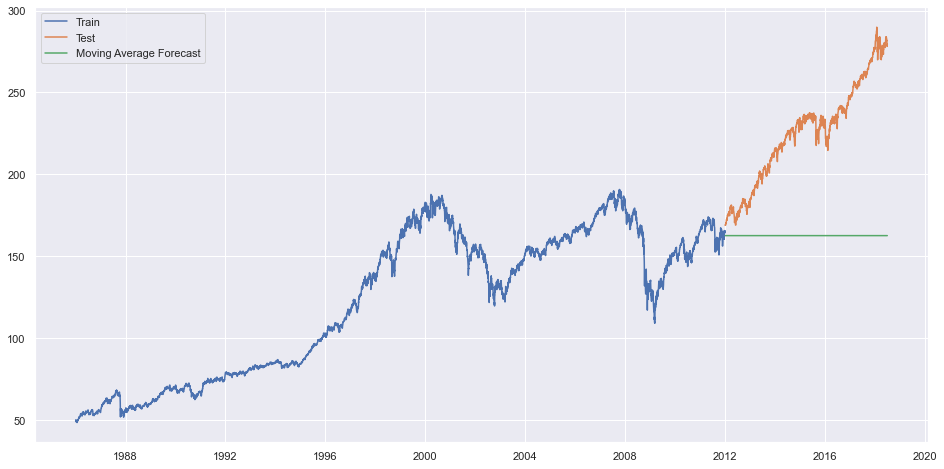

In [17]:
y_hat_avg = df_train_boxcox_test.copy()
y_hat_avg['moving_avg_forecast'] = df_train_boxcox['close'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(df_train_boxcox['close'], label='Train')
plt.plot(df_train_boxcox_test['close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

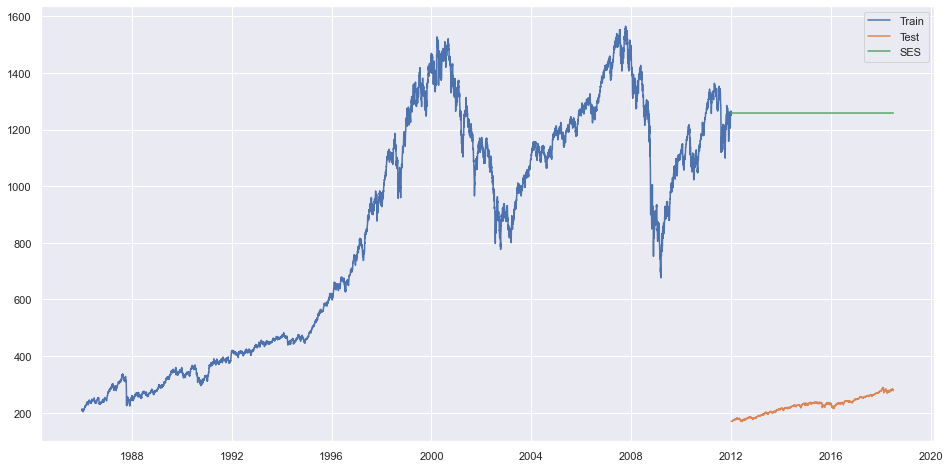

In [18]:
y_hat_avg = df_test.copy()
fit2 = SimpleExpSmoothing(np.asarray(df_train_2['close'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(df_test))
plt.figure(figsize=(16,8))
plt.plot(df_train_2['close'], label='Train')
plt.plot(df_test['close'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

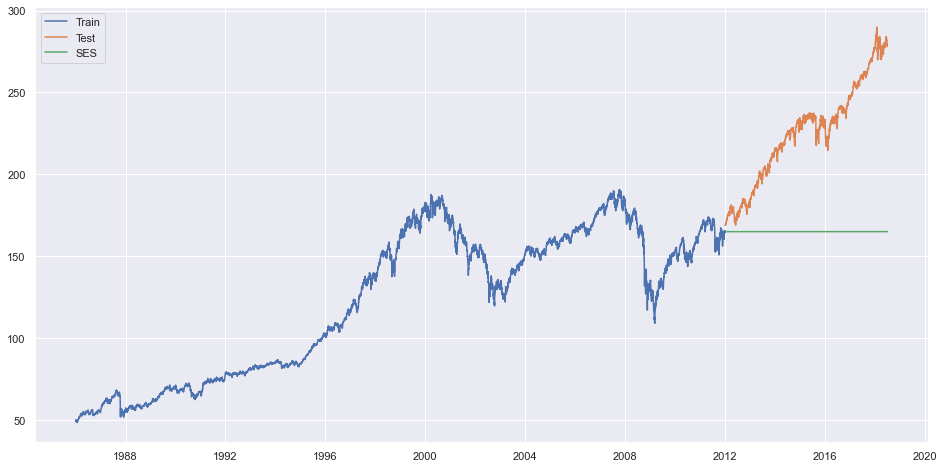

In [19]:
y_hat_avg = df_train_boxcox_test.copy()
fit2 = SimpleExpSmoothing(np.asarray(df_train_boxcox['close'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(df_train_boxcox_test))
plt.figure(figsize=(16,8))
plt.plot(df_train_boxcox['close'], label='Train')
plt.plot(df_train_boxcox_test['close'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

C:\Users\Pichau\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\Pichau\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


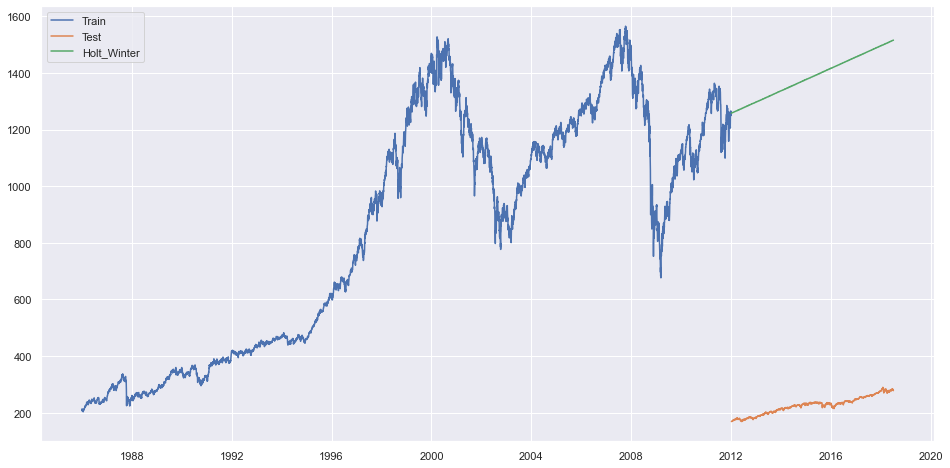

In [20]:
y_hat_avg = df_test.copy()
fit1 = ExponentialSmoothing(np.asarray(df_train_2['close']) ,seasonal_periods=6,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(df_test))
plt.figure(figsize=(16,8))
plt.plot(df_train_2['close'], label='Train')
plt.plot(df_test['close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

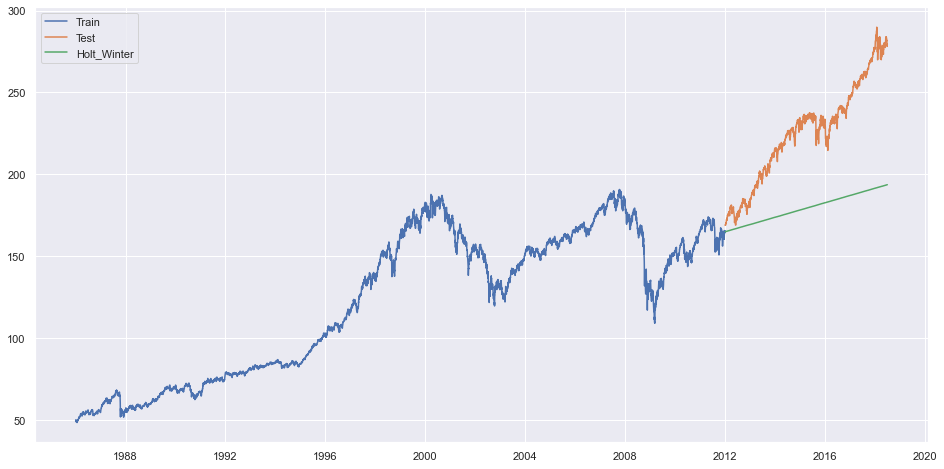

In [21]:
y_hat_avg = df_train_boxcox_test.copy()
fit1 = ExponentialSmoothing(np.asarray(df_train_boxcox['close']) ,seasonal_periods=6,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(df_train_boxcox_test))
plt.figure(figsize=(16,8))
plt.plot(df_train_boxcox['close'], label='Train')
plt.plot(df_train_boxcox_test['close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()